In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing-in-london/housing_in_london_monthly_variables.csv
/kaggle/input/housing-in-london/housing_in_london_yearly_variables.csv


# Loading the data

In [32]:
data_monthly = pd.read_csv('/kaggle/input/housing-in-london/housing_in_london_monthly_variables.csv', parse_dates= ['date'])

In [33]:
data_monthly.head()

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1


In [34]:
data_monthly.groupby('area').value_counts()

area                  date        average_price  code       houses_sold  no_of_crimes  borough_flag
barking and dagenham  2001-01-01  82343          E09000002  215.0        1771.0        1               1
                      2001-02-01  83266          E09000002  238.0        1600.0        1               1
                      2008-02-01  193699         E09000002  228.0        1626.0        1               1
                      2007-12-01  192458         E09000002  267.0        1518.0        1               1
                      2007-11-01  193603         E09000002  325.0        1630.0        1               1
                                                                                                      ..
westminster           2013-04-01  771734         E09000033  262.0        4621.0        1               1
                      2013-03-01  730982         E09000033  242.0        4726.0        1               1
                      2013-02-01  733269         E09000033  

In [35]:
data_monthly.isnull().value_counts()

date   area   average_price  code   houses_sold  no_of_crimes  borough_flag
False  False  False          False  False        False         False           7375
                                                 True          False           6080
                                    True         False         False             64
                                                 True          False             30
dtype: int64

In [36]:
data_monthly.drop('no_of_crimes', axis = 'columns')

,date,area,average_price,code,houses_sold,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,1
1,1995-02-01,city of london,82203,E09000001,7.0,1
2,1995-03-01,city of london,79121,E09000001,14.0,1
3,1995-04-01,city of london,77101,E09000001,7.0,1
4,1995-05-01,city of london,84409,E09000001,10.0,1
...,...,...,...,...,...,...
13544,2019-09-01,england,249942,E92000001,64605.0,0
13545,2019-10-01,england,249376,E92000001,68677.0,0
13546,2019-11-01,england,248515,E92000001,67814.0,0
13547,2019-12-01,england,250410,E92000001,NaN,0


# We will use only borough area's price to predict the house price. 

In [37]:
data_bf = data_monthly[data_monthly['borough_flag'] == 1]

In [38]:
data_bf.head()

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1


since no_of_crimes is not required for our analysis we will drop it from the table. 

In [39]:
data_bf = data_bf.drop("no_of_crimes", axis = 'columns')

In [40]:
data_bf.shape

(9936, 6)

In [41]:
#storing the areas that comes under boroughs flag in the areas dataframe. 

areas = data_bf.area.unique()

Now we will see the number of areas that comes under boroughs flag. 

In [42]:
for i, area in enumerate(areas):
    print(f'{i+1} - {area}')

1 - city of london
2 - barking and dagenham
3 - barnet
4 - bexley
5 - brent
6 - bromley
7 - camden
8 - croydon
9 - ealing
10 - enfield
11 - tower hamlets
12 - greenwich
13 - hackney
14 - hammersmith and fulham
15 - haringey
16 - harrow
17 - havering
18 - hillingdon
19 - hounslow
20 - islington
21 - kensington and chelsea
22 - kingston upon thames
23 - lambeth
24 - lewisham
25 - merton
26 - newham
27 - redbridge
28 - richmond upon thames
29 - southwark
30 - sutton
31 - waltham forest
32 - wandsworth
33 - westminster


In [43]:
data_bf.houses_sold.isnull().value_counts()

False    9867
True       69
Name: houses_sold, dtype: int64

Since there are only 69 entries with null values in the houses_sold column. we will fill it using the average value. 

In [44]:
data_bf['houses_sold'].fillna(data_bf.groupby('area')['houses_sold'].transform('mean'), inplace = True)

In [45]:
data_bf.houses_sold.isnull().value_counts()

False    9936
Name: houses_sold, dtype: int64

# Now our data is completely clean and can be used for further analysis. 

In [46]:
import numpy
import plotly.express as px 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [47]:
fig = px.box(data_bf, x="average_price", color = "borough_flag", title = "Average price 1995-2020")
fig.show()

In [48]:
fig1 = px.histogram(data_bf, x='average_price', y='houses_sold', nbins = 50)
fig1.show()

In [49]:
data_bf_date = data_bf.groupby(['date'])['average_price'].mean().to_frame().reset_index()
data_bf_date

,date,average_price
0,1995-01-01,81906.424242
1,1995-02-01,81527.969697
2,1995-03-01,81349.272727
3,1995-04-01,81432.515152
4,1995-05-01,82277.303030
...,...,...
296,2019-09-01,528443.060606
297,2019-10-01,525602.666667
298,2019-11-01,522975.878788
299,2019-12-01,524032.787879


In [50]:
fig2 = px.line(data_bf_date, x='date', y='average_price')
fig2.show()

In the above graph, We can clearly the drop of boroughs states during 2008-2009 in the housing price. 

In [51]:
# we will see the graph of average price specifically in the boroughs statewise.

data_bf_statewise = data_bf.groupby(['area'])['average_price'].mean().sort_values().to_frame().reset_index()
data_bf_statewise

,area,average_price
0,barking and dagenham,159852.930233
1,bexley,189570.737542
2,newham,195646.066445
3,havering,205026.664452
4,croydon,209349.671096
5,greenwich,213056.471761
6,lewisham,216601.893688
7,sutton,217273.445183
8,waltham forest,220395.159468
9,enfield,223130.629139


In [52]:
fig3 = px.bar(data_bf_statewise, x='area', y='average_price',
              template = 'simple_white')
fig3.show()

# We will now start with prediction 

In [53]:
from  sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.utils.validation import check_array

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score

In [54]:
data_bf.head()

,date,area,average_price,code,houses_sold,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,1
1,1995-02-01,city of london,82203,E09000001,7.0,1
2,1995-03-01,city of london,79121,E09000001,14.0,1
3,1995-04-01,city of london,77101,E09000001,7.0,1
4,1995-05-01,city of london,84409,E09000001,10.0,1


In [55]:
def preprocessing_data(df = data_bf, training_size = 0.8):
  # Drop unneccessary features
  df_predict = df.drop(columns =['code','houses_sold','borough_flag'])

  # Extract date feature
  df_predict['year'] = df_predict['date'].apply(lambda x: x.year)
  df_predict['month'] = df_predict['date'].apply(lambda x: x.month)
  df_predict = df_predict.drop(columns =['date'])

  # one hot encoding
  ohe = pd.get_dummies(df_predict['area'], drop_first= True)
  df_predict = pd.concat([df_predict,ohe], axis =1)
  df_predict = df_predict.drop(columns =['area'], axis =1)
 

  # Given x, y 
  x = df_predict.drop(columns = ['average_price'])
  y = df_predict['average_price']


  # Train-test split (train data 80%)
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= training_size, shuffle=True, random_state=42)

  # Standard scaling x
  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
  x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocessing_data()

In [56]:
x_train.sample(5)

,year,month,barnet,bexley,brent,bromley,camden,city of london,croydon,ealing,...,merton,newham,redbridge,richmond upon thames,southwark,sutton,tower hamlets,waltham forest,wandsworth,westminster
7352,-0.281175,-1.001861,-0.176076,-0.175696,-0.176834,-0.172241,-0.183899,-0.175696,-0.173014,-0.177589,...,-0.183899,5.728986,-0.176834,-0.176455,-0.179091,-0.177212,-0.176455,-0.177966,-0.177966,-0.172628
1905,-0.558151,-0.712809,-0.176076,-0.175696,-0.176834,-0.172241,5.437760,-0.175696,-0.173014,-0.177589,...,-0.183899,-0.174551,-0.176834,-0.176455,-0.179091,-0.177212,-0.176455,-0.177966,-0.177966,-0.172628
1537,-1.389078,0.732448,-0.176076,-0.175696,-0.176834,5.805809,-0.183899,-0.175696,-0.173014,-0.177589,...,-0.183899,-0.174551,-0.176834,-0.176455,-0.179091,-0.177212,-0.176455,-0.177966,-0.177966,-0.172628
1466,1.242192,1.310551,-0.176076,-0.175696,5.655020,-0.172241,-0.183899,-0.175696,-0.173014,-0.177589,...,-0.183899,-0.174551,-0.176834,-0.176455,-0.179091,-0.177212,-0.176455,-0.177966,-0.177966,-0.172628
1656,-0.004199,0.443396,-0.176076,-0.175696,-0.176834,5.805809,-0.183899,-0.175696,-0.173014,-0.177589,...,-0.183899,-0.174551,-0.176834,-0.176455,-0.179091,-0.177212,-0.176455,-0.177966,-0.177966,-0.172628


In [57]:
y_train.sample(5)

7815    426557
2139     81653
924      66659
4604    132325
7372    212391
Name: average_price, dtype: int64

In [58]:
knn = KNeighborsRegressor()
parameters = {'n_neighbors' : [2, 3, 5, 7],
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] ,
               }

grid_knn = GridSearchCV(estimator= knn, param_grid = parameters, cv = 3, n_jobs=-1)
grid_knn.fit(x_train, y_train)

# Print Best hyperparameters
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_knn.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_knn.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_knn.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 KNeighborsRegressor()

 The best score across ALL searched params:
 0.9872413671843098

 The best parameters across ALL searched params:
 {'algorithm': 'auto', 'n_neighbors': 5}


In [59]:
# Fitting with best params
knn_ft = grid_knn.best_estimator_
knn_ft.fit(x_train, y_train)

KNeighborsRegressor()

MSE: 335163307.8658752
RMSE: 18307.465905085694
R2: 0.9913215187807887


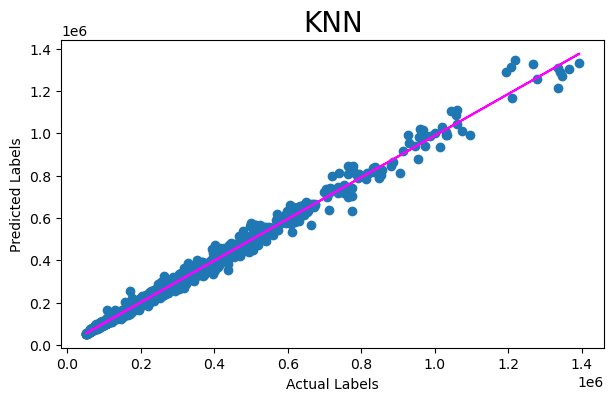

In [60]:
predictions = knn_ft.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.figure(figsize=(7, 4)) 
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('KNN', fontsize= 20)
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()